# ¿Qué juegos tienen éxito?

Trabajas para la tienda online Ice que vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas. Tienes que identificar patrones que determinen si un juego tiene éxito o no.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import math
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt
from statistics import mode

### Carga de datos

In [2]:
# Carga los archivos de datos 
df = pd.read_csv('/datasets/games.csv')

In [3]:
#Revisión rápida de tipos de datos, valores ausentes y títulos de las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<b>Descripción de datos</b>

- Name (Nombre)
- Platform (Plataforma)
- Year_of_Release (Año de lanzamiento)
- Genre (Género) 
- NA_sales (ventas en Norteamérica en millones de dólares estadounidenses) 
- EU_sales (ventas en Europa en millones de dólares estadounidenses) 
- JP_sales (ventas en Japón en millones de dólares estadounidenses) 
- Other_sales (ventas en otros países en millones de dólares estadounidenses) 
- Critic_Score (máximo de 100) 
- User_Score (máximo de 10) 
- Clasificación (ESRB)

### Preparar los datos

Para un mejor trabajo con los datos, se toma la decisión de cambiar todas las columnas a minúsculas.

In [4]:
#Convertimos los títulos de todas las columnas a minúsculas
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Verifiamos el porcentaje de valores ausentes en todas las columnas del DataFrame.

In [5]:
100*df.isna().sum()/df.shape[0]

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64

Las columnas critic_score, user_score y rating presentan un alto porcentaje de valores ausentes, pero al no poder ser imputables a otra columna, se continua el análisis conservando los valores ausentes.

Observamos que la columna name y genre presentan un porcentaje sumamente bajo de valores ausentes e iguales, asimismo, la columna year_of_release también presenta un porcentaje sumamente bajo de valores ausentes. Por este motivo se eliminaran las filas con valores ausentes de estas 3 columnas.

In [6]:
df = df.dropna(subset=['name'])
df = df.dropna(subset=['year_of_release'])
df = df.reset_index(drop=True)
df['year_of_release'] = df['year_of_release'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.4+ MB


La columna year_of_release se identifica que es de tipo flotante, así que se convierte a entero para poder hacer un uso adecuado de estos datos posteriormente.

Para la columna user_score se identifica que presenta el valor tbd, al representar únicamente el 14% de los datos del DataFrame se decir reemplazarlos por valores nulos.

In [7]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [8]:
tbd = df[df['user_score'] == 'tbd']

print('Porcentaje de juegos con score tbd: ')
print(100* len(tbd)/len(df))

Porcentaje de juegos con score tbd: 
14.449039163220627


In [9]:
df['user_score'] = df['user_score'].replace('tbd', 'nan')
df['user_score'] = df['user_score'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Se convierte el valor de user_score de string a float64, ya que no representa cadenas de datos, sino, valores numéricos.

Se agrega la columna total_sales que es la suma de las ventas de todas las regiones.

In [10]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


In [11]:
df.duplicated().sum()

0

El dataframe no presenta duplicados.

## Analizar los datos

In [12]:
games_per_year = df.groupby('year_of_release').name.count()

<AxesSubplot:title={'center':'Number of games sold per year'}, xlabel='year_of_release', ylabel='number of games'>

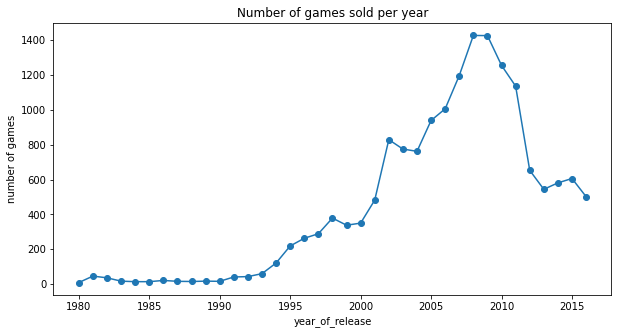

In [13]:
games_per_year.plot(style='o-', 
                    ylabel='number of games',
                    title='Number of games sold per year', 
                    figsize=(10,5)
                   )

Al analizar el número de juegos vendidos por año observamos que las ventas tenían una tendencia a subir empezando alrededor de 1995, porteriormente teniendo subidas importantes en los años 2000, 2005 y finalmente decreciendo conforme se va acercando al 2010.

In [14]:
def decade(year):
    if year <= 1989:
        return '80s'
    elif 1989 < year <= 1999:
        return '90s'
    elif 1999 < year <= 2009:
        return '2000s'
    elif year > 2009:
        return '2010s'

In [15]:
df['decade'] = df['year_of_release'].apply(decade)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,decade
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,2000s
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24,80s
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,2000s
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,2000s
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38,90s


In [16]:
games_per_decade = df.groupby('decade').name.count()
games_per_decade = games_per_decade[['80s','90s','2000s', '2010s']]
games_per_decade

decade
80s       205
90s      1769
2000s    9193
2010s    5277
Name: name, dtype: int64

<AxesSubplot:title={'center':'Number of games sold per decade'}, xlabel='decade', ylabel='number of games'>

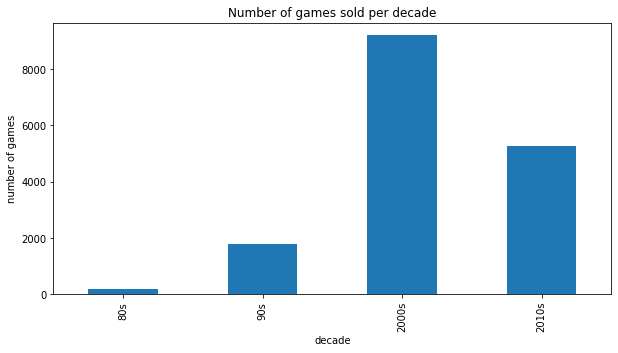

In [17]:
games_per_decade.plot(kind='bar',
                      ylabel='number of games',
                      title='Number of games sold per decade',
                      figsize=(10,5)
                     )

Agregamos la columna decade para observar el comportamiento en cada decada observando que de los 80s a los 90s se incrementaron las ventas, pero no tan drásticamente como de los 90s a los 2000s, posteriormente decreciendo para la decada de 2010, pero sin bajar tanto como se encontraba en los 90s.

In [18]:
sales_per_platform = df.groupby('platform')['total_sales'].agg('sum')
sales_per_platform = sales_per_platform.sort_values(ascending=False)

<AxesSubplot:xlabel='platform'>

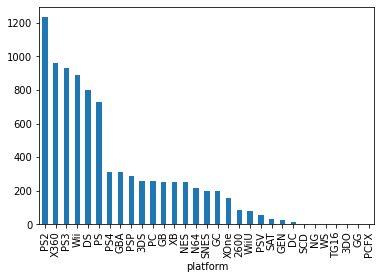

In [19]:
sales_per_platform.plot(kind='bar')

Las plataformas más vendidas son:

1) PS2

2) X360

3) PS3

4) Wii

5) DS

6) PS

<AxesSubplot:title={'center':'PS2'}, xlabel='year_of_release', ylabel='total_sales'>

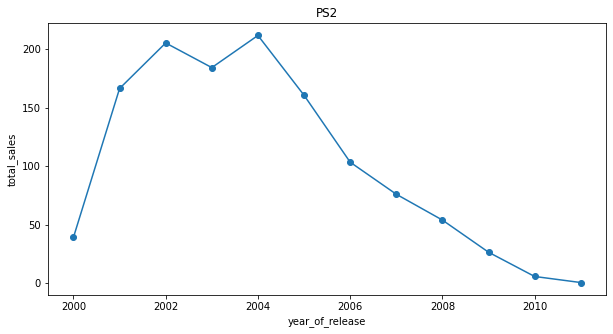

In [20]:
sales_ps2 = df[df['platform'] == 'PS2']
sales_ps2 = sales_ps2.groupby('year_of_release')['total_sales'].agg('sum')
sales_ps2.plot(style='o-',
               title='PS2',
               ylabel='total_sales',
               figsize=(10,5)
)

<AxesSubplot:title={'center':'X360'}, xlabel='year_of_release', ylabel='total_sales'>

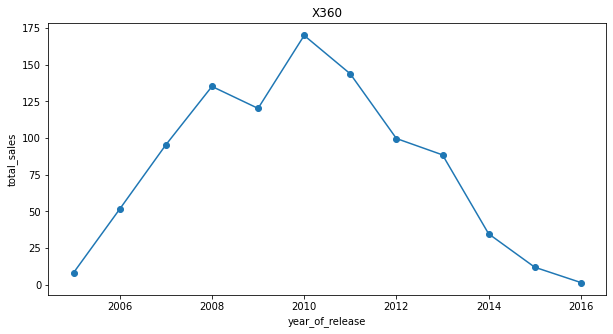

In [21]:
sales_x360 = df[df['platform'] == 'X360']
sales_x360 = sales_x360.groupby('year_of_release')['total_sales'].agg('sum')
sales_x360.plot(style='o-',
               title='X360',
               ylabel='total_sales',
               figsize=(10,5)
)

<AxesSubplot:title={'center':'PS3'}, xlabel='year_of_release', ylabel='total_sales'>

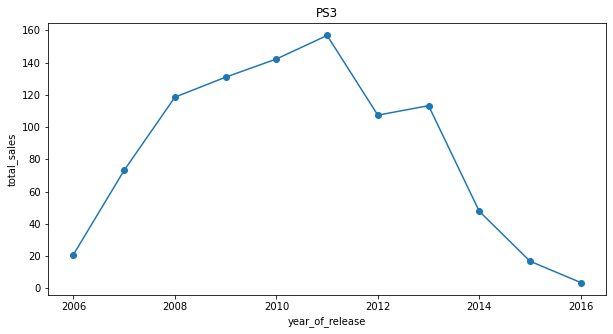

In [22]:
sales_ps3 = df[df['platform'] == 'PS3']
sales_ps3 = sales_ps3.groupby('year_of_release')['total_sales'].agg('sum')
sales_ps3.plot(style='o-',
               title='PS3',
               ylabel='total_sales',
               figsize=(10,5)
)

<AxesSubplot:title={'center':'Wii'}, xlabel='year_of_release', ylabel='total_sales'>

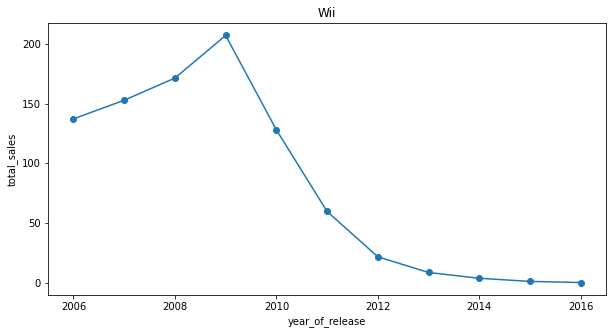

In [23]:
sales_wii = df[df['platform'] == 'Wii']
sales_wii = sales_wii.groupby('year_of_release')['total_sales'].agg('sum')
sales_wii.plot(style='o-',
               title='Wii',
               ylabel='total_sales',
               figsize=(10,5)
)

<AxesSubplot:title={'center':'DS'}, xlabel='year_of_release', ylabel='total_sales'>

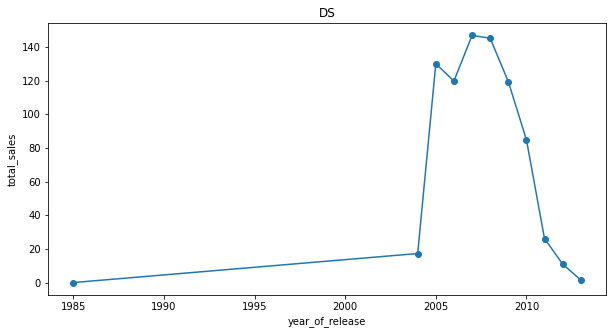

In [24]:
sales_ds = df[df['platform'] == 'DS']
sales_ds = sales_ds.groupby('year_of_release')['total_sales'].agg('sum')
sales_ds.plot(style='o-',
               title='DS',
               ylabel='total_sales',
               figsize=(10,5)
)

<AxesSubplot:title={'center':'PS'}, xlabel='year_of_release', ylabel='total_sales'>

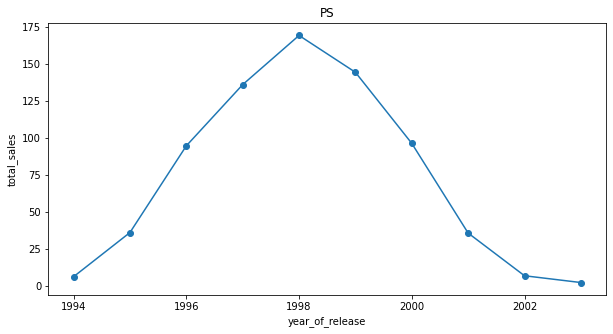

In [25]:
sales_ps = df[df['platform'] == 'PS']
sales_ps = sales_ps.groupby('year_of_release')['total_sales'].agg('sum')
sales_ps.plot(style='o-',
               title='PS',
               ylabel='total_sales',
               figsize=(10,5)
)

Observamos que cada plataforma tiene un tiempo de vida de aproximadamente 10 años, los primeros 5 con ventas crecientes y los siguientes 5 con ventas decrecientes. Adicionalmente, se identifica que la plataforma DS presenta datos atípicos, ya que la consola no se había estrenado en el año 1985, al ser esta una única fila, se procede a eliminarla.

In [26]:
df.drop(df[(df['platform'] == 'DS') & (df['year_of_release'] == 1985)].index, inplace=True)

<AxesSubplot:title={'center':'DS'}, xlabel='year_of_release', ylabel='total_sales'>

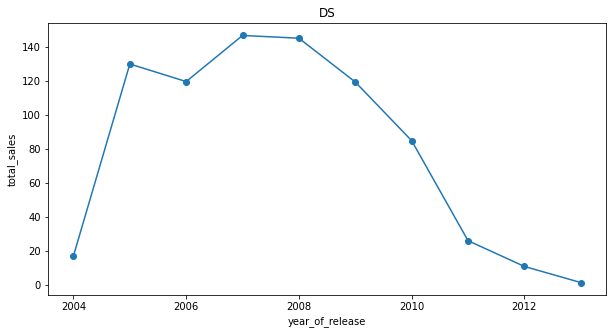

In [27]:
sales_ds = df[df['platform'] == 'DS']
sales_ds = sales_ds.groupby('year_of_release')['total_sales'].agg('sum')
sales_ds.plot(style='o-',
               title='DS',
               ylabel='total_sales',
               figsize=(10,5)
)

Con estos datos podemos determinar que para generar predicciones para el año 2017, tenemos que trabajar únicamente con los datos de los 10 años previos.

In [28]:
df_refined = df.query('year_of_release >= 2007')

<AxesSubplot:xlabel='platform'>

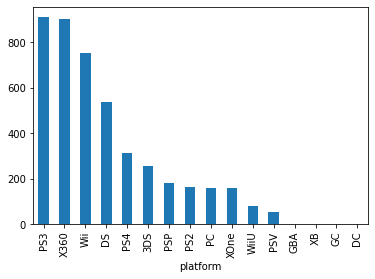

In [29]:
sales_per_platform = df_refined.groupby('platform')['total_sales'].agg('sum')
sales_per_platform = sales_per_platform.sort_values(ascending=False)
sales_per_platform.plot(kind='bar')

Observamos que las plataformas conn mayores ventas son:

1) PS3

2) X360

3) Wii

4) DS

Pero haremos el mismo ejercicio que en la ocasión pasada para observar las plataformas que van decreciendo y las que van en incremento.

<AxesSubplot:title={'center':'PS3 since 2007'}, xlabel='year_of_release', ylabel='total_sales'>

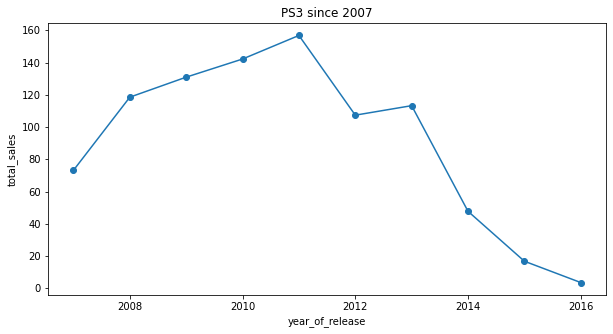

In [30]:
sales_ps3 = df_refined[df_refined['platform'] == 'PS3']
sales_ps3 = sales_ps3.groupby('year_of_release')['total_sales'].agg('sum')
sales_ps3.plot(style='o-',
               title='PS3 since 2007',
               ylabel='total_sales',
               figsize=(10,5)
)

Observamos que el PS3 tuvo su pico de ventas en 2011, pero actualmente se encuentra en decremento, así que no sería potencialmente rentable.

<AxesSubplot:title={'center':'X360 since 2007'}, xlabel='year_of_release', ylabel='total_sales'>

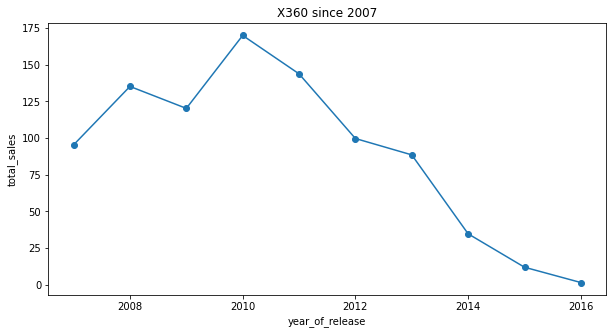

In [31]:
sales_x360 = df_refined[df_refined['platform'] == 'X360']
sales_x360 = sales_x360.groupby('year_of_release')['total_sales'].agg('sum')
sales_x360.plot(style='o-',
               title='X360 since 2007',
               ylabel='total_sales',
               figsize=(10,5)
)

Al igual que el PS3 el X360 se encuentra en decremento.

<AxesSubplot:title={'center':'Wii since 2007'}, xlabel='year_of_release', ylabel='total_sales'>

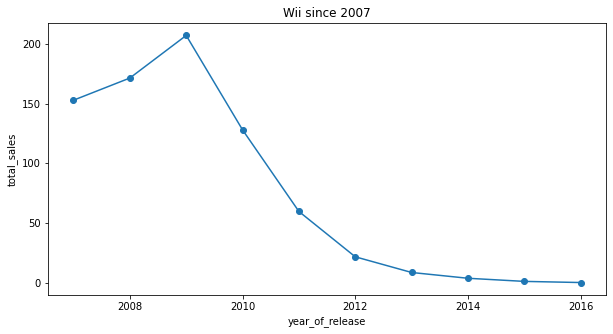

In [32]:
sales_wii = df_refined[df_refined['platform'] == 'Wii']
sales_wii = sales_wii.groupby('year_of_release')['total_sales'].agg('sum')
sales_wii.plot(style='o-',
               title='Wii since 2007',
               ylabel='total_sales',
               figsize=(10,5)
)

Wii igualmente en decremento.

<AxesSubplot:title={'center':'DS since 2007'}, xlabel='year_of_release', ylabel='total_sales'>

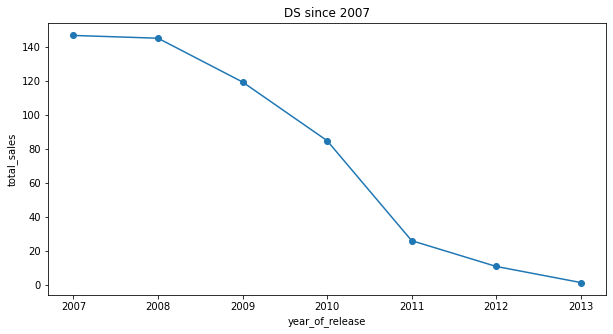

In [33]:
sales_ds = df_refined[df_refined['platform'] == 'DS']
sales_ds = sales_ds.groupby('year_of_release')['total_sales'].agg('sum')
sales_ds.plot(style='o-',
               title='DS since 2007',
               ylabel='total_sales',
               figsize=(10,5)
)

Para el DS observamos que ya ni siquiera presenta ventas después de 2013.

<AxesSubplot:title={'center':'PS4 since 2007'}, xlabel='year_of_release', ylabel='total_sales'>

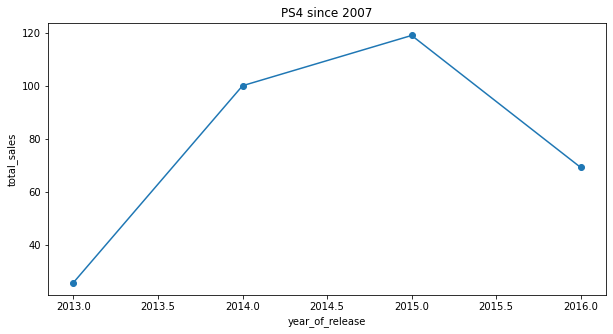

In [34]:
sales_ps4 = df_refined[df_refined['platform'] == 'PS4']
sales_ps4 = sales_ps4.groupby('year_of_release')['total_sales'].agg('sum')
sales_ps4.plot(style='o-',
               title='PS4 since 2007',
               ylabel='total_sales',
               figsize=(10,5)
)

El PS4 comenzó sus ventas en 2013, si sigue la tendencia común, para 2017 sería su último año en incremento y comenzaría a decrementar, como se ve de 2015 a 2016, por lo tanto, tampoco se podría considerar una plataforma potencialmente rentable.

<AxesSubplot:title={'center':'3DS since 2007'}, xlabel='year_of_release', ylabel='total_sales'>

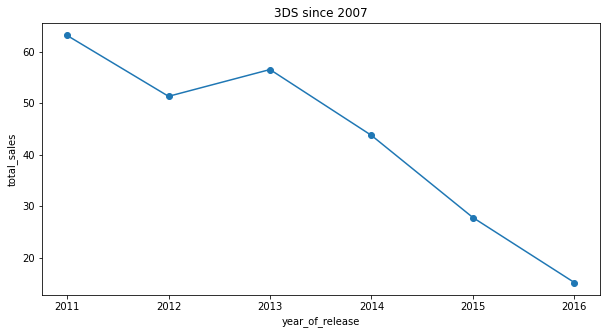

In [35]:
sales_3ds = df_refined[df_refined['platform'] == '3DS']
sales_3ds = sales_3ds.groupby('year_of_release')['total_sales'].agg('sum')
sales_3ds.plot(style='o-',
               title='3DS since 2007',
               ylabel='total_sales',
               figsize=(10,5)
)

3DS comenzó con un pico de ventas en su estreno en 2011, pero con el paso de los años sus ventas se han ido reduciendo, por lo tanto, tampoco se podría considerar una plataforma potencialmente rentable.

<AxesSubplot:title={'center':'PSP since 2007'}, xlabel='year_of_release', ylabel='total_sales'>

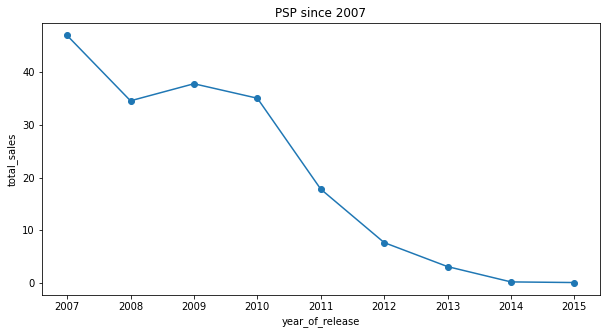

In [36]:
sales_psp = df_refined[df_refined['platform'] == 'PSP']
sales_psp = sales_psp.groupby('year_of_release')['total_sales'].agg('sum')
sales_psp.plot(style='o-',
               title='PSP since 2007',
               ylabel='total_sales',
               figsize=(10,5)
)

PSP igualmente se encuentra en decremento.

<AxesSubplot:title={'center':'PC since 2007'}, xlabel='year_of_release', ylabel='total_sales'>

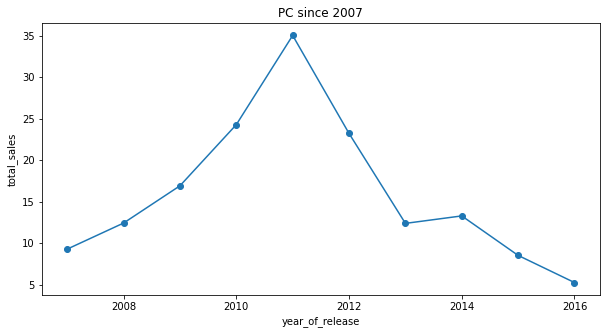

In [37]:
sales_pc = df_refined[df_refined['platform'] == 'PC']
sales_pc = sales_pc.groupby('year_of_release')['total_sales'].agg('sum')
sales_pc.plot(style='o-',
               title='PC since 2007',
               ylabel='total_sales',
               figsize=(10,5)
)

PC igualmente se encuentra en decremento.

<AxesSubplot:title={'center':'XOne since 2007'}, xlabel='year_of_release', ylabel='total_sales'>

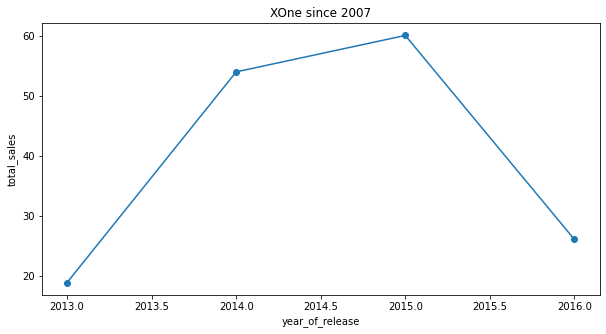

In [38]:
sales_xone = df_refined[df_refined['platform'] == 'XOne']
sales_xone = sales_xone.groupby('year_of_release')['total_sales'].agg('sum')
sales_xone.plot(style='o-',
               title='XOne since 2007',
               ylabel='total_sales',
               figsize=(10,5)
)

XOne al igual que PS4 comenzó sus ventas en 2013, si sigue la tendencia común, para 2017 sería su último año en incremento y comenzaría a decrementar, como se ve de 2015 a 2016, por lo tanto, tampoco se podría considerar una plataforma potencialmente rentable.

<AxesSubplot:title={'center':'WiiU since 2007'}, xlabel='year_of_release', ylabel='total_sales'>

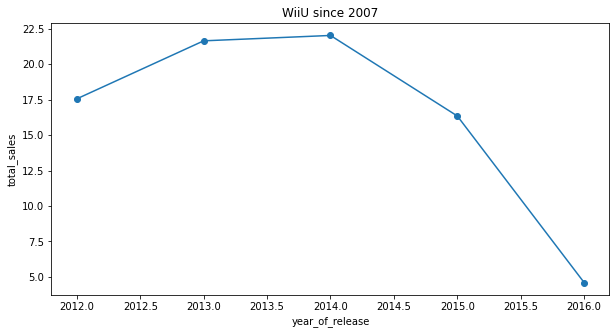

In [39]:
sales_wiiu = df_refined[df_refined['platform'] == 'WiiU']
sales_wiiu = sales_wiiu.groupby('year_of_release')['total_sales'].agg('sum')
sales_wiiu.plot(style='o-',
               title='WiiU since 2007',
               ylabel='total_sales',
               figsize=(10,5)
)

WiiU igualmente en decremento.

Como conclusión de este análisis, se observa que las consolas de Play Station y Xbox han presentado muy buenas ventas, siguiendo la tendencia común, por tanto, se recomendaría considerar como potencialmente rentables las siguientes generaciones de estas consolas, ya que para 2017 las actuales como son PS4 y XOne van en decremento.

## Crea un perfil de usuario para cada región

<AxesSubplot:xlabel='platform'>

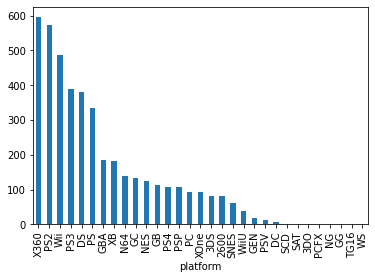

In [40]:
sales_per_platform_na = df.groupby('platform')['na_sales'].agg('sum')
sales_per_platform_na = sales_per_platform_na.sort_values(ascending=False)
sales_per_platform_na.plot(kind='bar')

Para la región NA las 5 principales plataformas son:

1) X360

2) PS2

3) Wii

4) PS3

5) DS

<AxesSubplot:xlabel='platform'>

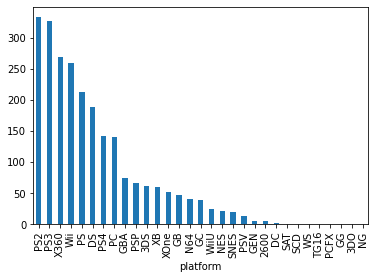

In [41]:
sales_per_platform_eu = df.groupby('platform')['eu_sales'].agg('sum')
sales_per_platform_eu = sales_per_platform_eu.sort_values(ascending=False)
sales_per_platform_eu.plot(kind='bar')

Para la región EU las 5 principales plataformas son:

1) PS2

2) PS3

3) X360

4) WII

5) PS

<AxesSubplot:xlabel='platform'>

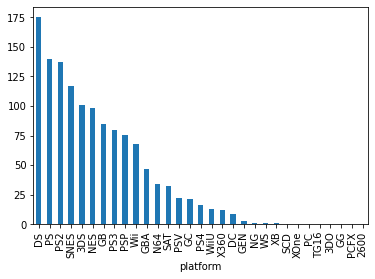

In [42]:
sales_per_platform_jp = df.groupby('platform')['jp_sales'].agg('sum')
sales_per_platform_jp = sales_per_platform_jp.sort_values(ascending=False)
sales_per_platform_jp.plot(kind='bar')

Para la región JP las 5 principales plataformas son:

1) DS

2) PS

3) PS2

4) SNES

5) 3DS

Al observar las 3 gráficas observamos que en la región NA la principal plataforma es Xbox, pero se visualiza una popularidad algo inferior pero bastante alta del resto de plataformas de Nintendo y Play Station. En la región de EU se nota una clara tendencia por las plataformas de Play Station y en la región JP por las plataformas de Nintendo.

<AxesSubplot:xlabel='genre'>

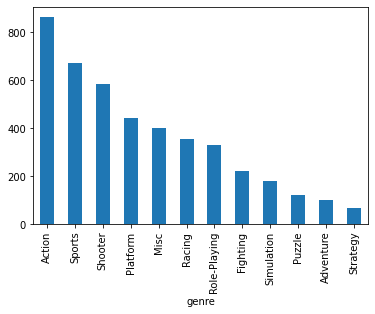

In [43]:
sales_per_genre_na = df.groupby('genre')['na_sales'].agg('sum')
sales_per_genre_na = sales_per_genre_na.sort_values(ascending=False)
sales_per_genre_na.plot(kind='bar')

<AxesSubplot:xlabel='genre'>

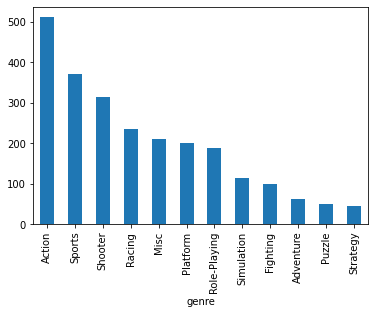

In [44]:
sales_per_genre_eu = df.groupby('genre')['eu_sales'].agg('sum')
sales_per_genre_eu = sales_per_genre_eu.sort_values(ascending=False)
sales_per_genre_eu.plot(kind='bar')

<AxesSubplot:xlabel='genre'>

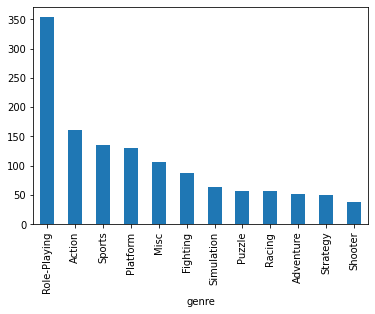

In [45]:
sales_per_genre_jp = df.groupby('genre')['jp_sales'].agg('sum')
sales_per_genre_jp = sales_per_genre_jp.sort_values(ascending=False)
sales_per_genre_jp.plot(kind='bar')

Al observar las 3 gráficas observamos que los géneros principales en las 3 regiones son Action, Sports, Shooter, Platform and Misc, con la excepción de la región de JP donde el género con más ventas es Role-playing.

<AxesSubplot:xlabel='rating'>

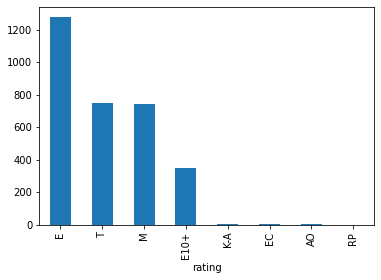

In [46]:
sales_per_rating_na = df.groupby('rating')['na_sales'].agg('sum')
sales_per_rating_na = sales_per_rating_na.sort_values(ascending=False)
sales_per_rating_na.plot(kind='bar')

<AxesSubplot:xlabel='rating'>

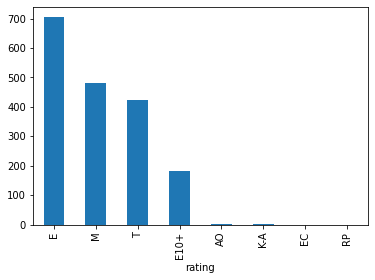

In [47]:
sales_per_rating_eu = df.groupby('rating')['eu_sales'].agg('sum')
sales_per_rating_eu = sales_per_rating_eu.sort_values(ascending=False)
sales_per_rating_eu.plot(kind='bar')

<AxesSubplot:xlabel='rating'>

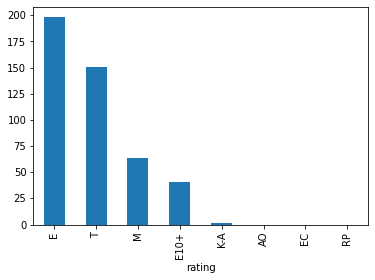

In [48]:
sales_per_rating_jp = df.groupby('rating')['jp_sales'].agg('sum')
sales_per_rating_jp = sales_per_rating_jp.sort_values(ascending=False)
sales_per_rating_jp.plot(kind='bar')

Al observar los 3 gráficos no se considera que la clasificación tenga influencias en las ventas en regiones individuales.

## Prueba las hipótesis

La primer hipótesis que deseamos comprobar es si las calificaciones promedio de los usuarios para la plataforma Xbox One y PC son las mismas.

Para comprobar lo anterior determinamos nuestra hipótesis nula que sería: "Las calificaciones promedio de los usuarios para la plataforma Xbox One y PC son las mismas" y nuestra hipótesis alternativa sería: "Las calificaciones promedio de los usuarios para la plataforma Xbox One y PC no son las mismas"

In [50]:
#Para el valor esperado usamos el promedio de user_score para la plataforma Xbox One
mean_user_score = df.query('platform == "XOne"')
mean_user_score = mean_user_score['user_score'].mean()
mean_user_score

6.521428571428572

In [51]:
#Creamos la variable pc_user_score que contiene los valores de user_score para la plataforma PC quitando los valores nulos
pc_user_score = df.query('platform == "PC"')
pc_user_score = pc_user_score.dropna(subset=['user_score'])
pc_user_score = pc_user_score.reset_index(drop=True)

In [52]:
alpha = 0.05

results = st.ttest_1samp(pc_user_score['user_score'], mean_user_score)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('Rechazamos la hipótesis nula')
else:
    print("No rechazamos la hipótesis nula")

p-value:  2.8031532083563148e-21
Rechazamos la hipótesis nula


Con el resultado obtenido, se rechaza la hipótesis nula, lo que nos indica que las calificaciones promedio para estas 2 plataformas no son las mimsmas.

Nuestra siguiente hipótesis nula es: "Las calificaciones promedio para el género de acción y deportes es la misma".
Nuestra hipótesis alternativa es: "Las calificaciones promedio para el género de acción y deportes no es la misma".

In [53]:
#Para el valor esperado usamos el promedio de user_score para el género Action
mean_user_score = df.query('genre == "Action"')
mean_user_score = mean_user_score['user_score'].mean()
mean_user_score

7.058129175946546

In [54]:
#Creamos la variable sports_user_score que contiene los valores de user_score para el genero de deportes quitando los valores nulos
sports_user_score = df.query('genre == "Sports"')
sports_user_score = pc_user_score.dropna(subset=['user_score'])
sports_user_score = pc_user_score.reset_index(drop=True)

In [55]:
alpha = 0.05

results = st.ttest_1samp(sports_user_score['user_score'], mean_user_score)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('Rechazamos la hipótesis nula')
else:
    print("No rechazamos la hipótesis nula")

p-value:  0.8883900653747717
No rechazamos la hipótesis nula


Con base en los resultados obtenidos, no rechazamos la hipótesis nula, lo que quiere decir que, las calificaciones promedio para estos 2 géneros son las mismas.

## Conclusiones

Como conclusión de este proyecto observamos que había valores ausentes que se podían eliminar al presentar un porcentaje muy bajo, había otras columnas con muchos valores ausentes, pero al no poder ser relacionados con otras columnas, no se pudo imputar los datos y se decidió conservar los valores ausentes de dichas columnas.

Posteriormente, se analizaron las ventas totales de las diferentes plataformas para obtener las más populares a nivel global y observando que las plataformas tienen un tiempo de vida promedio de 10 años, 5 años en crecimiento y 5 años en decremento. Con esta información se buscó alguna plataforma que estuviera en crecimiento, pero actualmente todas se encontraban en decremento o sin ventas, lo que nos deja ver que estamos en un momento de transición donde nuevas plataformas surgen para sustituir a las que van en decremento de ventas.

Adicionalmente observamos que la región influye en las plataformas más usadas, pero no influyendo de igual forma en los géneros y clasificación de los juegos, presentando un comportamiento bastante similar en todas las regiones, salvo algunas excepciones como que en la región JP el género de Role-playing es el más popular.

Como conlusión general, se considera que las plataformas más prometedoras serían las siguientes generaciones de las plataformas de Play Station y Xbox.